# Modelo XGBoost

In [10]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import os

In [11]:
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [12]:
# Eliminar CATEGORIA = 2
df_filtrado = df[df['CATEGORIA'] != 2].copy()

# Remapear categorías a consecutivas 0..K-1
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Definir modelo XGBoost

### Division de data test y prueba

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Definir XGBoost utilizado

In [14]:
use_gpu = False  # True si hay CUDA y xgboost con soporte GPU

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",  # multi-clase
    eval_metric="mlogloss",
    tree_method="gpu_hist" if use_gpu else "hist",
    device="cuda" if use_gpu else "cpu",
    n_jobs=-1,
    random_state=42
)

### Entrenamiento

In [15]:
t0 = time.perf_counter()
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],       # útil para early_stopping
    verbose=False
)
t1 = time.perf_counter()
fit_s = t1 - t0
print(f"⏱ XGBoost – entrenamiento: {fit_s:.2f}s")

# TEST
t0 = time.perf_counter()
y_pred = xgb.predict(X_test)
t1 = time.perf_counter()
pred_s = t1 - t0
print(f"⏱ XGBoost – predicción: {pred_s:.3f}s  ({pred_s/len(y_test)*1000:.2f} ms/muestra)")


⏱ XGBoost – entrenamiento: 2.41s
⏱ XGBoost – predicción: 0.020s  (0.00 ms/muestra)


### Matriz de confusion

## Metricas

In [16]:
oa  = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
cm  = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))
cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

print(f"OA: {oa:.3f}")
print(f"F1 macro: {f1m:.3f}")
print("Etiquetas (orden en matriz):", np.sort(y.unique()).tolist())
print("Matriz de confusión:\n", cm)
print("\nReporte por clase:\n", classification_report(y_test, y_pred, digits=3))
print("Matriz de confusión porcentajeo:\n", cm_row_percentage)

OA: 0.887
F1 macro: 0.829
Etiquetas (orden en matriz): [0, 1, 2, 3, 4, 5]
Matriz de confusión:
 [[2229  216    0    4    2    8]
 [ 174 4266    0    7   16  105]
 [   8    1  317   10    0    0]
 [   4   13   10  276   22   29]
 [  21   52    0   11  276   52]
 [  26  139    0   20   39  407]]

Reporte por clase:
               precision    recall  f1-score   support

           0      0.905     0.906     0.906      2459
           1      0.910     0.934     0.922      4568
           2      0.969     0.943     0.956       336
           3      0.841     0.780     0.809       354
           4      0.777     0.670     0.720       412
           5      0.677     0.645     0.661       631

    accuracy                          0.887      8760
   macro avg      0.847     0.813     0.829      8760
weighted avg      0.885     0.887     0.886      8760

Matriz de confusión porcentajeo:
 [[9.06466043e+01 8.78405856e+00 0.00000000e+00 1.62667751e-01
  8.13338756e-02 3.25335502e-01]
 [3.80910683

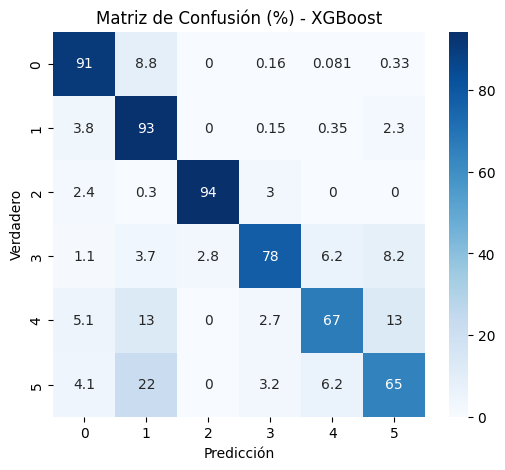

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- calcular matriz de confusión con los últimos resultados ---
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm_row_percentage, annot=True, cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión (%) - XGBoost")
plt.show()

# Registrar informacion

In [18]:
import sys
sys.path.append("..")
import importlib, utils_log
importlib.reload(utils_log)
from utils_log import log_row

carpeta_actual = ruta_carpeta_actual.split("\\")[-1]
dataset_utilizado = csv_path.split("\\")[-1]

log_row(
  script="20250901_PruebasEntrenamientoXGB.ipynb",
  algoritmo="XGBoost",
  dataset=dataset_utilizado,
  clases_removidas=[2],
  seed=42,
  n_train=len(y_train), n_test=len(y_test),
  n_features=X.shape[1], num_classes=len(sorted(y.unique())),
  fit_seconds=fit_s,
  pred_seconds=pred_s,
  ms_per_sample=(pred_s/len(y_test))*1000,
  OA=oa, F1_macro=f1m,
  carpeta=carpeta_actual
)